# Application 2: Sleep apnea detection using electrocardiography


<i>DTEK2093-3002 Machine Learning Health Technology Project </i>

<i>Spring 2025 </i>
* <b>Saara Mäkelä </b>
  * 2203834
* <b>Matilda Laurila </b>
  * 2110294



In [2]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from scipy import interpolate
import xgboost as xgb
import os

In [3]:
# paths to the directories
apnea_test_path = 'Data/Data/Test/apnea/'
apnea_train_path = 'Data/Data/Train/apnea/'
normal_test_path = 'Data/Data/Test/normal/'
normal_train_path = 'Data/Data/Train/normal/'

fs = 100 #Hz

In [4]:
def load_data(path):
    """ 
    Loads the data from the path to a dictionary and takes the key from the filename
    """
    file_list = os.listdir(path)
    data = defaultdict(list)
    for filename in file_list:
        subject_id = filename.split('_')[1].replace('.txt', '')
        file_path = os.path.join(path, filename)
        data[subject_id].append(np.loadtxt(file_path))
    key_list = list(data.keys())
    return data, key_list

def filtering(signalz, fs):
    """ 
    Filters the data using NeuroKit2 function ecg_clean() with method "neurokit" which is a 5th order 0.5 Hz high-pass butterworth filter
    """
    cleaned = nk.ecg_clean(signalz, sampling_rate=fs, method="neurokit")
    return cleaned

def resample(array, orig_ts, new_ts):
    """"
    Resample the signals with given timestamps using cubic spline interpolation
    """
    interp_f = interpolate.interp1d(orig_ts, array, kind='cubic', fill_value="extrapolate")
    resampled = interp_f(new_ts)
    return resampled

def preprocess_data_ecg(data_dict, fs_orig=100, fs_new=1000):
    """
    Full preprocessing for ECG dataset:
    - Filters signals
    - Segments each 5-min ECG signal into 1-min chunks
    - Resamples each 1-min segment to 1000 Hz using cubic spline
    """
    processed_dict = {}
    for key, recordings in data_dict.items():
        subject_segments = []
        for record in recordings:
            cleaned = filtering(record, fs=fs_orig)
            # Minute by minute segments
            samples_per_minute = 60 * fs_orig
            total_segments = len(cleaned) // samples_per_minute
            for i in range(total_segments):
                start = i * samples_per_minute
                end = start + samples_per_minute
                segment = cleaned[start:end]
                # Resample from 100 Hz to 1000 Hz
                orig_ts = np.linspace(0, 60, num=len(segment), endpoint=False)
                new_ts = np.linspace(0, 60, num=60 * fs_new, endpoint=False)
                resampled_segment = resample(segment, orig_ts, new_ts)
                subject_segments.append(resampled_segment)
        processed_dict[key] = subject_segments
    return processed_dict

def peak_detection(filtered_data, fs):
    """ 
    Finds the peaks from the data using NeuroKit2 function ecg_peaks()
    """
    peaks = {}
    for key in filtered_data:
        subject_records = filtered_data[key]
        records_peaks = []
        for record in subject_records:
            _, rpeaks = nk.ecg_peaks(record, sampling_rate=fs)
            records_peaks.append(rpeaks['ECG_R_Peaks'])
        peaks[key] = records_peaks
    return peaks

def plot_ecg_with_peaks(signalz, peaks, title):
    """ 
    Makes visualization of the signal and the detected peaks
    """
    plt.rcParams['figure.figsize'] = [15, 5]
    signals, info = nk.ecg_process(signalz)
    nk.ecg_plot(signals, info)
    plt.title(title)
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(signalz, label='ECG Signal')
    plt.scatter(peaks, [signalz[i] for i in peaks], color='red', label='R-Peaks', zorder=5)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def extract_hrv_features(peaks, fs):
    """ 
    Generates the wanted HRV features using two different NeuroKit2 functions and combines them to a single dataframe
    """
    rpeaks_dict = {"ECG_R_Peaks": np.array(peaks)}
    hrv_features = nk.hrv_time(rpeaks_dict, sampling_rate=fs, show=False)
    hrv_freq = nk.hrv_frequency(rpeaks_dict, sampling_rate=fs)
    hrv_df = pd.concat([hrv_features[['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_MedianNN', 'HRV_pNN50', 'HRV_MinNN', 'HRV_MaxNN']], hrv_freq[['HRV_LF', 'HRV_HF']]], axis=1)
    return hrv_df

def extract_all_hrv(peaks, fs):
    """ 
    Generates through the dictionary and finds out HRV features for each record that has enough peaks. Adds a column 'Subject' to the dataframe to store the subject info
    """
    hrv_data = []
    for key in peaks:
        for record_peaks in peaks[key]:
            if len(record_peaks) < 2:
                print(f"Skipping segment for {key} — not enough peaks.")
                continue
            features = extract_hrv_features(record_peaks, fs)
            features["Subject"] = key
            hrv_data.append(features)
    return pd.concat(hrv_data, ignore_index=True)

def standardize_train_test(X_train, X_test):
    """ 
    Standardizes the given data
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def LOGO_CV_input_model(X, y, groups, model):
    """ 
    Makes a Leave-One-Group-Out cross-validation to the given data using the model given to it and grouping by subject in the data
    """
    logo = LeaveOneGroupOut()
    accuracy_sum = 0
    y_test_all = []
    y_pred_all = []

    for train_idx, test_idx in logo.split(X, y, groups=groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_s, X_test_s = standardize_train_test(X_train, X_test)

        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_sum += accuracy

        y_pred_all.append(y_pred)
        y_test_all.append(y_test)

    print('Average accuracy: %.2f%%' % ((accuracy_sum / logo.get_n_splits(groups=groups)) * 100))
    
    cm = confusion_matrix(np.concatenate(y_test_all), np.concatenate(y_pred_all))
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Apnea'])
    disp.plot()
    plt.show()

def model_evaluation(X, y, X_test, y_test, model):
    """ 
    Evaluates the model by using the train and test data
    """
    model.fit(X, y)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test.astype(int), y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Test accuracy: %.2f%%' % (accuracy*100))
    print(f'Precision: {precision:.2f}')
    print(f'Recall:    {recall:.2f}')
    print(f'F1 Score:  {f1:.2f}')

    plt.figure(figsize=(15,4))
    plt.plot(y_test, 'ro')
    plt.plot(y_pred, 'bx')
    plt.title('Predictions and true labels')
    plt.legend(['True', 'Predicted'])
    plt.yticks(ticks = [0, 1], labels=['Normal', 'Apnea'])
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Apnea'])


## 1. Pre-processing

The project included the ECG records of 64 subjects (i.e., 51 for training and 13 for test). The number of records per subject varied; some subjects had only one record, while some had more than 20 recordings. Each record (i.e., file) included 5 minutes of ECG signals, and it corresponded to either sleep apnea or normal sleep. We familiarized ourselves with the data and concluded that our approach for this data structure would be a dictionary. The subject id was the key and all of the records from the subject were saved as lists behind the key. 

In [5]:
apnea_train_data, apnea_train_keys = load_data(apnea_train_path)
apnea_test_data, apnea_test_keys = load_data(apnea_test_path)
normal_train_data, normal_train_keys = load_data(normal_train_path)
normal_test_data, normal_test_keys = load_data(normal_test_path)

In [9]:
dict(list(apnea_train_data.items())[0:3])

{'subj1': [array([-0.21 , -0.225, -0.22 , ...,  0.085,  0.025,  0.01 ]),
  array([-0.05 , -0.045, -0.06 , ..., -0.165, -0.165, -0.19 ]),
  array([-0.025, -0.035, -0.005, ..., -0.105, -0.135, -0.12 ]),
  array([-0.24 , -0.285, -0.645, ..., -0.14 , -0.015,  0.05 ]),
  array([-0.705, -0.65 , -0.605, ...,  0.05 ,  0.105,  0.165]),
  array([-0.09 , -0.09 , -0.11 , ..., -0.785, -0.775, -0.78 ]),
  array([-0.415, -0.45 , -0.465, ...,  0.145,  0.13 ,  0.14 ]),
  array([-0.035, -0.05 , -0.065, ..., -0.145, -0.1  , -0.06 ]),
  array([ 0.005,  0.06 ,  0.08 , ..., -0.01 ,  0.   , -0.05 ]),
  array([ 0.3  ,  0.25 ,  0.255, ..., -0.23 , -0.19 , -0.235]),
  array([-0.13 , -0.175, -0.18 , ...,  0.355,  0.49 ,  0.515]),
  array([-0.225, -0.22 , -0.215, ..., -0.045, -0.06 , -0.08 ])],
 'subj20': [array([-0.08 , -0.075, -0.13 , ..., -0.035,  0.02 , -0.045]),
  array([ 2.955,  3.15 ,  0.07 , ..., -0.015, -0.075, -0.05 ]),
  array([-0.025, -0.135, -0.1  , ..., -0.13 , -0.115, -0.165]),
  array([-0.155, -0.

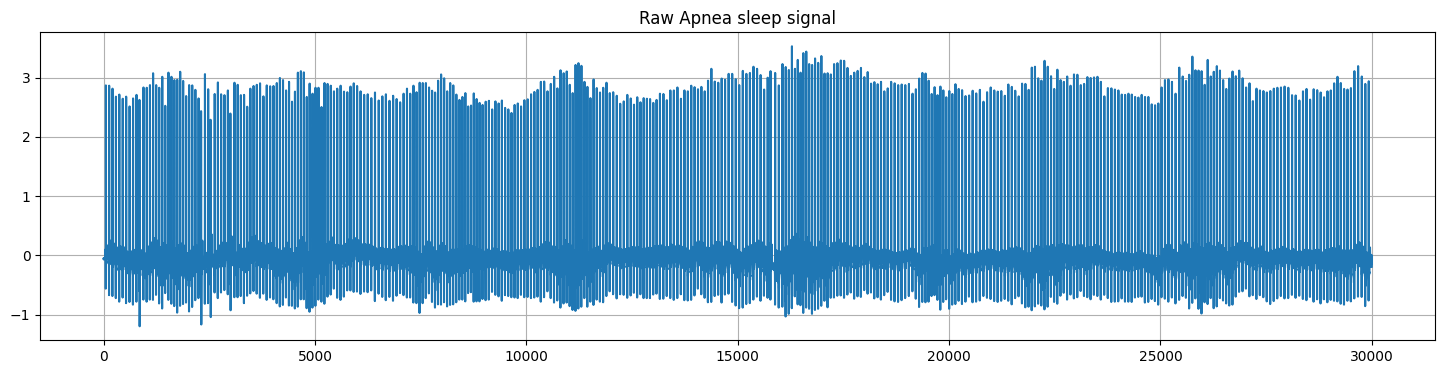

In [10]:
plt.figure(figsize=(18,4))
plt.plot(apnea_train_data[apnea_train_keys[0]][1])
plt.title('Raw Apnea sleep signal')
plt.grid(True)

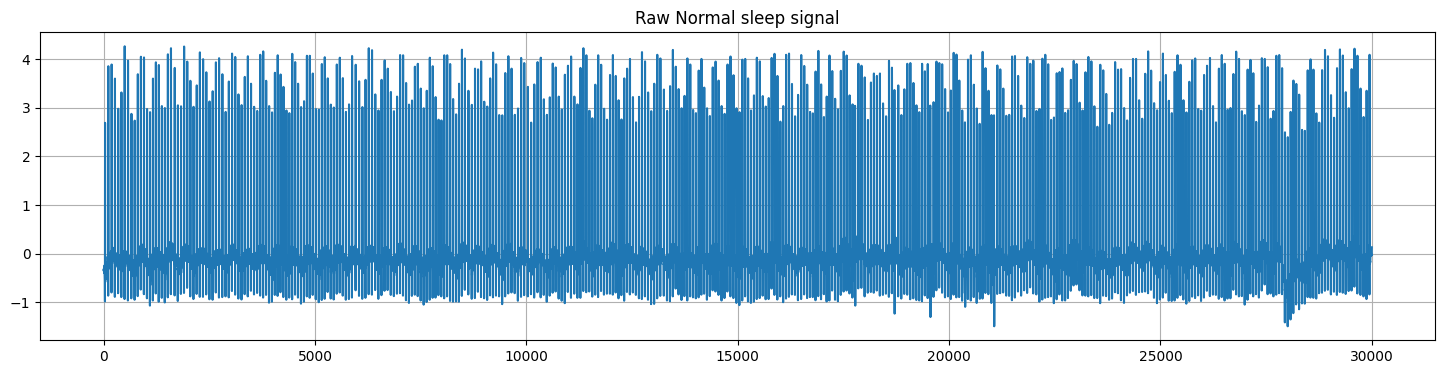

In [11]:
plt.figure(figsize=(18,4))
plt.plot(normal_train_data[normal_train_keys[0]][1])
plt.title('Raw Normal sleep signal')
plt.grid(True)

<i>Here are just random examples from same subject's both signals so we can see how they look and compare them. In these signals the difference between apnea and normal signal is easy to spot. In the apnea signal the R-peaks go kind of in waves, first going down and then up and again down in some point. The hight of R-peaks differs through the signal in cycles. When the R-peaks in apnea plot are at the highest there is also increase in beats. There are more beats at those moments and the spaces between beats decrease or disappear. There are also segments in normal data where the spaces between beats disappear but they don't go in as clear cycles as in the apnea plot. The normal signal is somewhat same through the whole signal. But there is some kind of cycle through the signal in normal plot as well, couple of high R-peaks and the couple of lower R-peaks.  

In apnea plot, the noticeable decrease in the heart rate presented by the time interval between R-peaks increasing is <b>bradycardia</b>. Slowing of heart rate happens when breathing stops in apnea episode and oxygen levels in the blood begin to decrease and carbon dioxide levels increase. Body senses the change and the immediate response is to slow down the heart rate to conserve oxygen. Bradycardia is often followed by a return to the baseline heart rate or a temporary increase after apnea ends. The temporary increase in heart rate presented by time interval between R-peaks decreasing is <b>tachycardia</b>. As the apnea episode ends and breathing resumes, the oxygen levels start to rise and carbon dioxide levels decrease. </i><font>[(1)](https://publications.ersnet.org/content/erj/41/6/1439) </font>


<font>From the study [(2)](https://ieeexplore.ieee.org/document/898631) provided we understood that we would get the best results if we executed a minute by minute classification of the data. In order to increase the time-resolution of the original data, we interpolated the ECG signal using cubic splines and the resampled the data with 1000 Hz. The minute by minute classification increased the number of datapoints in the datasets and therefore created a larger training and testing sets. We were hopeful that this change would provide better results. </font>

In [11]:
new_fs = 1000 # Hz
processed_train_apnea = preprocess_data_ecg(apnea_train_data, fs, new_fs)
processed_test_apnea = preprocess_data_ecg(apnea_test_data, fs, new_fs)
processed_train_normal = preprocess_data_ecg(normal_train_data, fs, new_fs)
processed_test_normal = preprocess_data_ecg(normal_test_data, fs, new_fs)

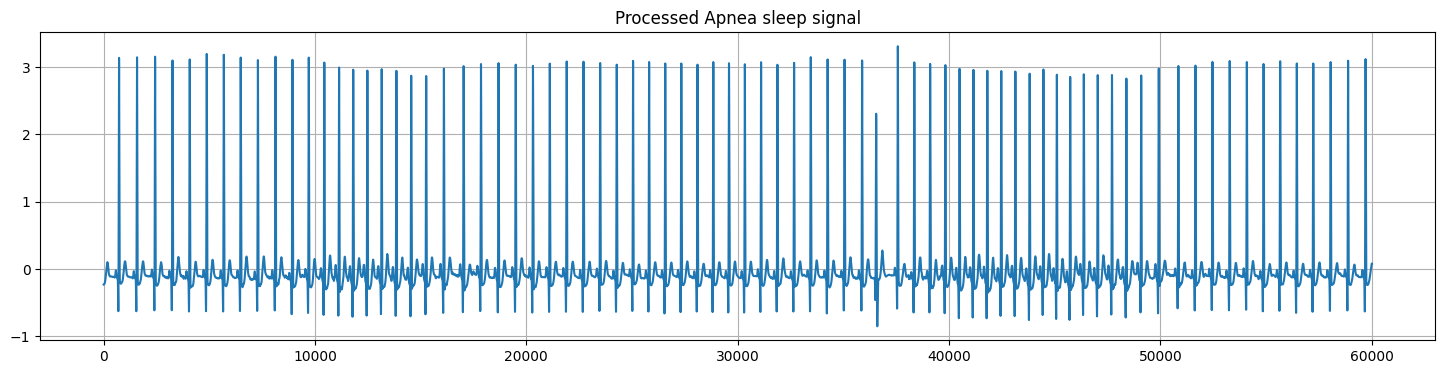

In [16]:
plt.figure(figsize=(18,4))
plt.plot(processed_train_apnea[apnea_train_keys[0]][1])
plt.title('Processed Apnea sleep signal')
plt.grid(True)

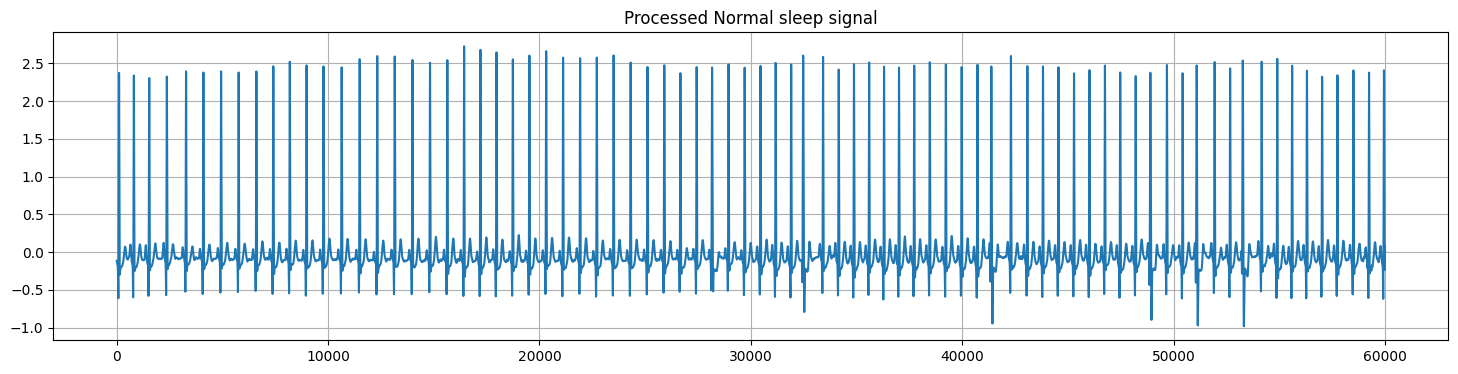

In [17]:
plt.figure(figsize=(18,4))
plt.plot(processed_train_normal[normal_train_keys[0]][1])
plt.title('Processed Normal sleep signal')
plt.grid(True)

<i>After resampling we can see the changes in the signals better as they are in shorter segments. Small changes would get lost in 5 minute segments but minute by minute segmentation makes them easier to spot.</i>

## 2. Peak detection

In [16]:
peaks_apnea_train = peak_detection(processed_train_apnea, new_fs)
peaks_apnea_test = peak_detection(processed_test_apnea, new_fs)
peaks_normal_train = peak_detection(processed_train_normal, new_fs)
peaks_normal_test = peak_detection(processed_test_normal, new_fs)

When we did the peak detection we discovered that after resampling and processing the data contained one low quality segment for which the functions were unable to detect peaks. As it was only about one segment we decided this wouldn't affect the data too much if we excluded the segment. We simply created functions that would first check that the segment had enough peaks and then continue. Otherwise the peaks were well detected.

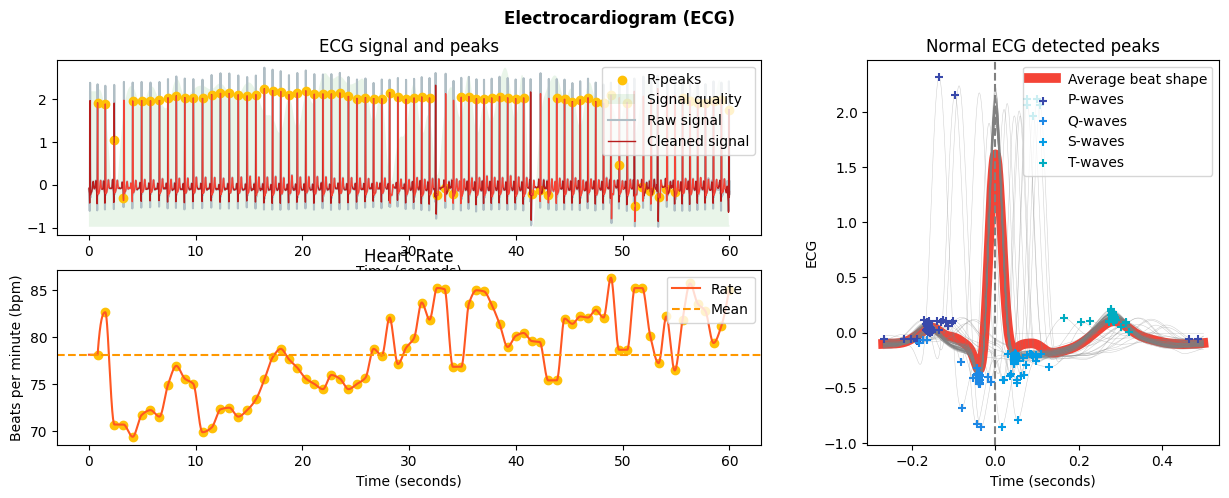

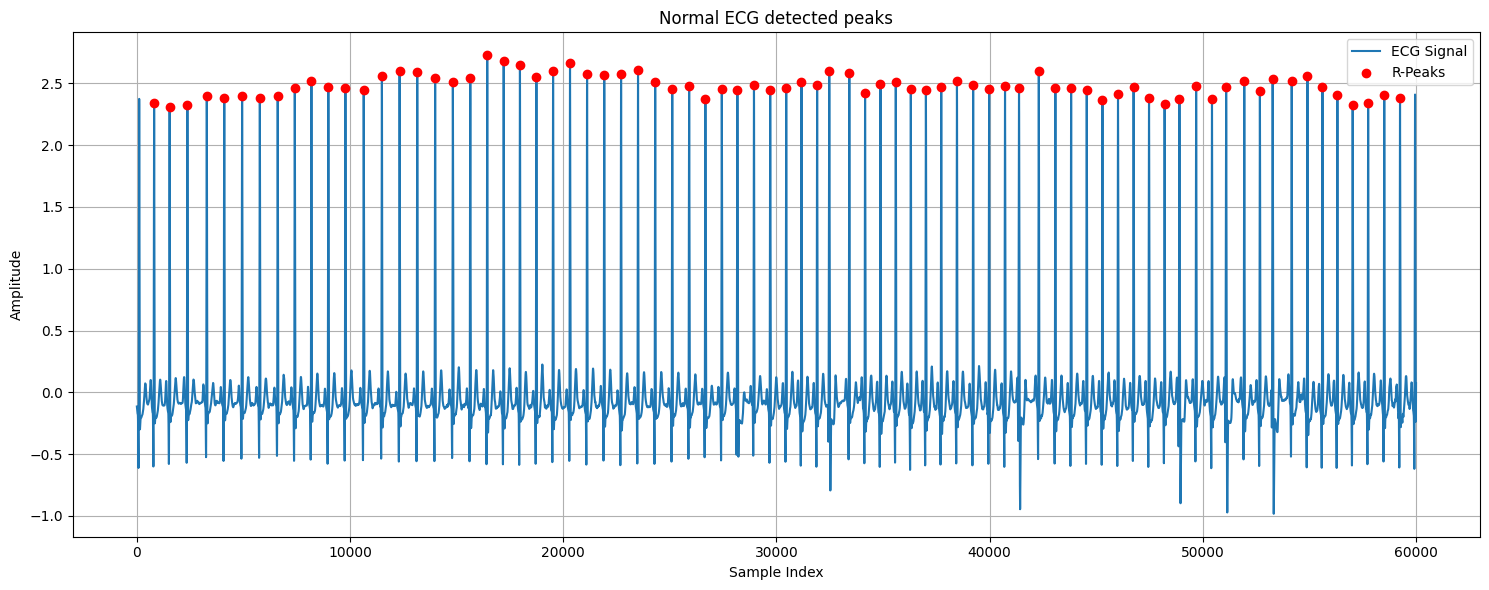

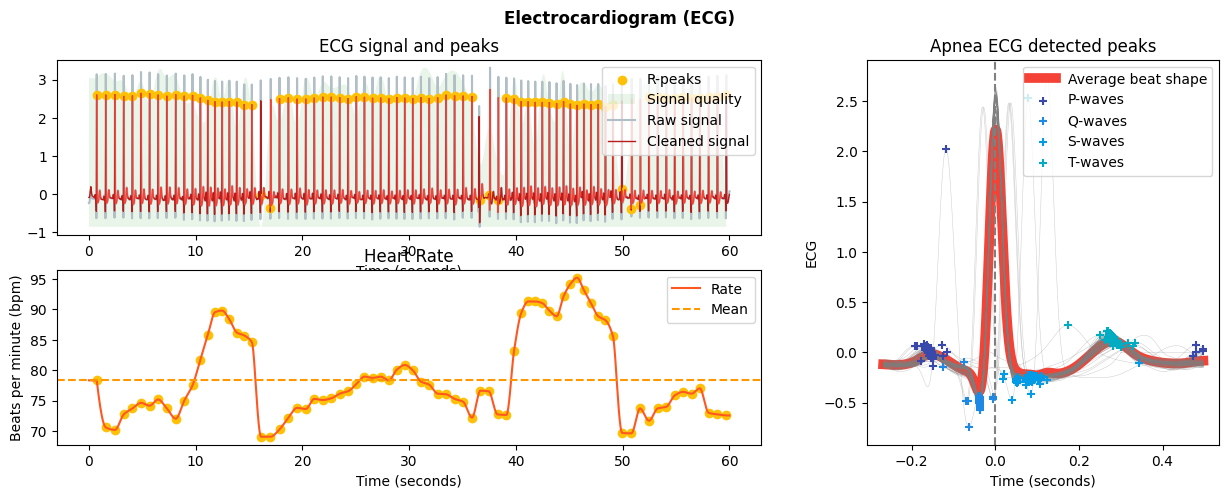

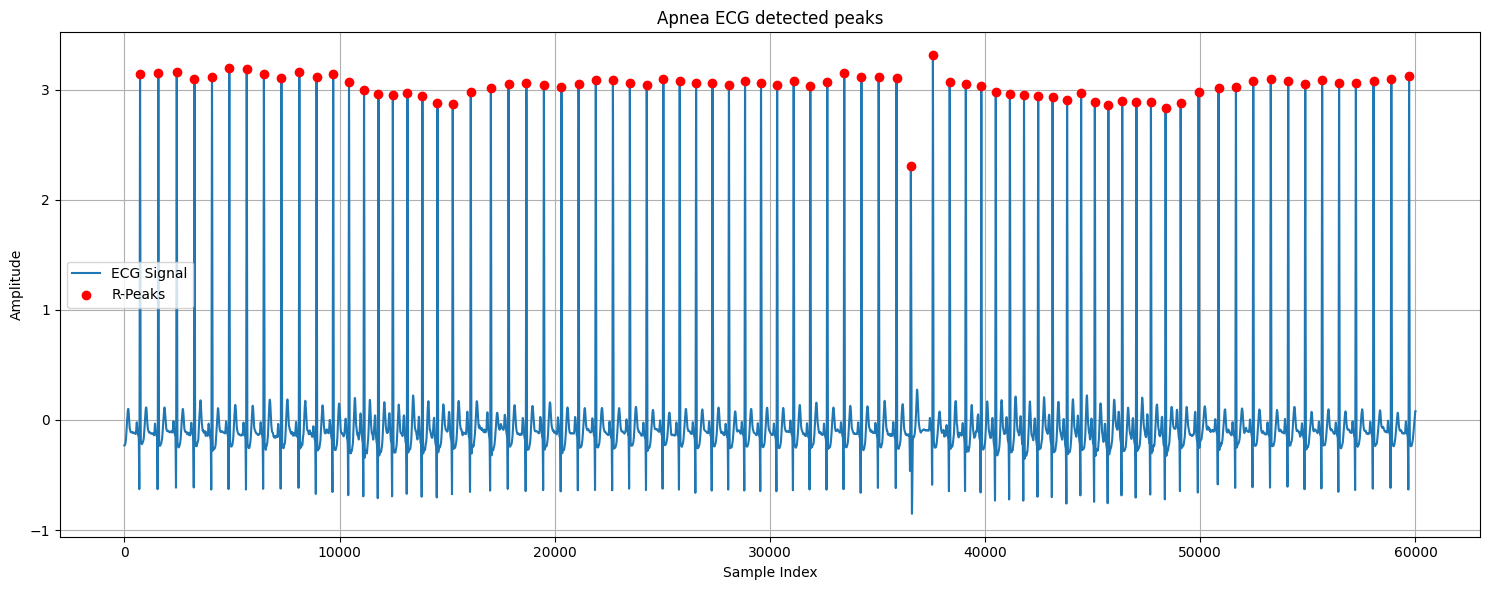

In [20]:
z = plot_ecg_with_peaks(processed_train_normal[normal_train_keys[0]][1], peaks_normal_train[normal_train_keys[0]][1], "Normal ECG detected peaks")
z = plot_ecg_with_peaks(processed_train_apnea[apnea_train_keys[0]][1], peaks_apnea_train[apnea_train_keys[0]][1], "Apnea ECG detected peaks")

<i> From these plots we can first see a visualization method provided by NeuroKit2 package. After that the peaks detected from the data are visualized. Based on these plots we can say that the peak detection function works well. The NeuroKit2 visualization method can't detect peaks as well as the `ecg_peaks()` we are using. The function can detect peaks even if the signal has some irregularities. 

From the beats per minute heart rates we can see clear difference for these segments. For normal ECG the heart rates are between 70-85 bpm. For apnea ECG the heart rates are between 70-95 bpm. The variation is greater and also the graphs look different. From apnea heart rate graph we can see quite steady heart rates and then suddenly the heart rate goes up quickly. Those are the segments when the breathing cessations unravel. When compared to the peaks detected by our function, decrease in the hights of R-peaks in those moments can be seen. The decrease is easier to spot with knowing the heart rates at those moments. </i>

## 3. HRV feature extraction

<font>For HRV features we decided to follow the project instructions and take into consideration the mean of the RR intervals, the standard deviation of the RR intervals, the square root of the mean of the squared successive differences between adjacent RR intervals, the median of the RR intervals, the percentage of absolute differences in successive RR intervals greater than 50 ms, the minimum of the RR intervals, the maximum of the RR intervals, the spectral power of low frequencies and the spectral power of high frequencies. 

In addition we tried to take the entropy of the heart rate signals into consideration. However, the calculation of entropy per signal took a considerable time even after downsampling. And the benefit of the entropy was slim to none as we could detect decrease of the accuracy for both of the classification models. Therefore we decided to exclude the entropy from the final results.

In group we discussed the number of HRV features to consider. During this project we calculated all of the HRV features the NeuroKit2 functions `hrv_time()` and `hrv_freq()` gave. Nonetheless we decided to settle for these nine features only. Some of the features the functions gave were NaN values for every signal and therefore useless. Also we thought about the possibility that if we gave too many features to the classification models, the possibility for incorrect observations and characterizations from data would increase substantially. In conclusion we decided that this composed number of features to consider would be best for this situation. </font>


In [21]:
apnea_train_hrv = extract_all_hrv(peaks_apnea_train, new_fs)
apnea_test_hrv = extract_all_hrv(peaks_apnea_test, new_fs)
normal_train_hrv = extract_all_hrv(peaks_normal_train, new_fs)
normal_test_hrv = extract_all_hrv(peaks_normal_test, new_fs)
display(apnea_train_hrv)

Skipping segment for subj6 — not enough peaks.


,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_MedianNN,HRV_pNN50,HRV_MinNN,HRV_MaxNN,HRV_LF,HRV_HF,Subject
0,734.283951,66.900343,24.943687,725.0,6.172840,619.0,891.0,0.008547,0.003629,subj1
1,765.883117,74.453266,64.352442,785.0,11.688312,631.0,1025.0,0.046428,0.023274,subj1
2,779.276316,60.801886,32.117700,786.5,9.210526,662.0,918.0,0.010251,0.020937,subj1
3,786.706667,82.794727,32.102244,809.0,6.666667,619.0,917.0,0.023232,0.005598,subj1
4,795.067568,90.289539,35.416891,825.5,5.405405,611.0,926.0,0.030511,0.003308,subj1
...,...,...,...,...,...,...,...,...,...,...
1459,946.887097,202.739687,302.348946,975.0,53.225806,577.0,1409.0,0.005183,0.140480,subj16
1460,975.750000,235.759546,322.898840,930.0,36.666667,659.0,1933.0,0.053887,0.059700,subj16
1461,926.812500,151.102601,196.228689,913.0,15.625000,666.0,1927.0,0.046387,0.083421,subj16
1462,923.718750,62.203830,33.210010,923.0,10.937500,814.0,1087.0,0.002852,0.008172,subj16


So far we had handled the data from different directories completely separately. We needed to merge the dataframes into one training dataframe and one testing dataframe. As we needed to differentiate the ECG segments into two classes, we added "Label" column that indicated 1 for the signals collected during obstructive sleep apnea and 0 for the signals collected in normal sleep.

In [22]:
apnea_train_hrv['Label'] = 1
normal_train_hrv['Label'] = 0
apnea_test_hrv['Label'] = 1
normal_test_hrv['Label'] = 0

In [23]:
train_data = pd.concat([apnea_train_hrv, normal_train_hrv])
test_data = pd.concat([apnea_test_hrv, normal_test_hrv])

The method we used stacked the apnea data and normal data. We decided to shuffle the data so that the data would be more balanced and wouldn't change directly from one type to another. By doing this we tried to prevent the model from learning wrong information of the structure of the data. We noticed that this affects the RandomForestClassifier.

In [25]:
all_train = train_data.sample(frac=1).reset_index(drop=True)
all_test = test_data.sample(frac=1).reset_index(drop=True)

In [26]:
display(all_train)

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_MedianNN,HRV_pNN50,HRV_MinNN,HRV_MaxNN,HRV_LF,HRV_HF,Subject,Label
0,931.126984,51.699034,25.910516,927.0,7.936508,847.0,1050.0,0.004131,0.006829,subj52,1
1,851.000000,52.988067,28.417062,854.0,7.246377,766.0,983.0,0.003488,0.008601,subj52,1
2,875.323529,41.400282,45.371929,870.5,32.352941,796.0,971.0,0.017171,0.078195,subj65,0
3,768.311688,31.432995,36.089436,765.0,3.896104,682.0,934.0,0.012582,0.001449,subj8,1
4,766.415584,66.721604,48.510715,765.0,23.376623,647.0,969.0,0.035652,0.036348,subj33,0
...,...,...,...,...,...,...,...,...,...,...,...
3114,707.939759,75.317110,17.800041,697.0,3.614458,609.0,876.0,0.005540,0.001692,subj51,0
3115,862.970588,87.598468,70.955420,859.0,41.176471,716.0,1103.0,0.008404,0.015994,subj66,1
3116,829.323944,63.472328,16.781793,824.0,1.408451,738.0,1013.0,0.014959,0.001608,subj50,1
3117,721.073171,31.539425,9.758187,730.0,0.000000,659.0,777.0,0.016872,0.002547,subj51,1


## 5. Machine learning algorithm, Leave-One-Group/Subject-Out cross-validation

<font> We decided to use the Leave-One-Group-Out cross-validation method as a machine learning algorithm. It provides train/test indices to split data such that each training set is comprised of all samples except ones belonging to one specific group[(3)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html). This was ideal in this case as there are multiple records per subject in both the apnea training set and the normal training set. So in order to prevent data leakage, possible bias and overfitting, this was our chosen course of action. 

For classifiers we decided to use RandomForestClassifier[(4)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and XGBClassifier[(5)](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier). Random Forest handles HRV feature sets well, can handle noise well, doesn't require too much preprocessing and is not prone to overfitting to individual patients. Gradient boosting (XGB) is optimized for finding complex dependencies, it handles missing values well, and is often used in clinical machine learning. Both of these are commonly used with ECG data.</font>

During this project we tried different classification models such as SVM, KNN and Logistic Regression but we settled for these as we were the most satisfied with the results they provided. 

In [27]:
X = all_train.drop(columns=["Subject", "Label"]).values
y = all_train["Label"].values
x_test_set = all_test.drop(columns=["Subject", "Label"]).values
y_test_set = all_test["Label"].values
subjects = all_train["Subject"].values

Average accuracy: 68.16%


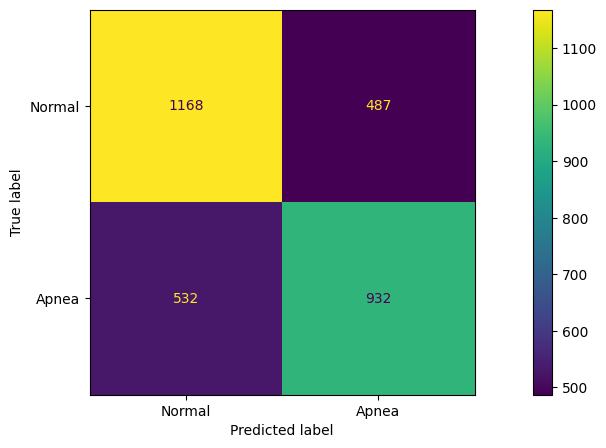

In [28]:
model_1 = RandomForestClassifier(random_state=42)
random_forest = LOGO_CV_input_model(X, y, subjects, model_1)

Average accuracy: 66.14%


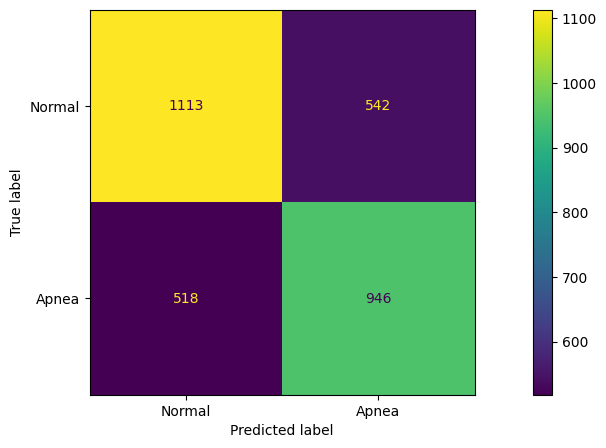

In [29]:
model_2 = xgb.XGBClassifier()
xgboost = LOGO_CV_input_model(X, y, subjects, model_2)

<i>RandomForestClassifier gives average accuracy 68,16% and the XGBClassifier gives 66,14%. These numbers are not great. Both of them predict most of the cases correctly but they are not very reliable. This could not be implemented for practical use. Both of the models can detect true normal the best. </i>

## 6. Classifier evaluation

Test accuracy: 66.41%
Precision: 0.63
Recall:    0.75
F1 Score:  0.68


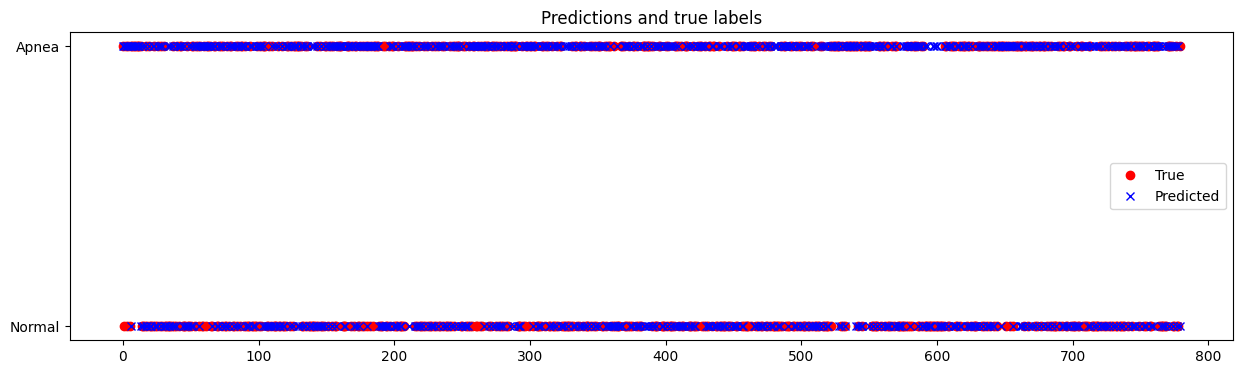

In [30]:
model_1e = RandomForestClassifier(random_state=42)
rf_evaluation = model_evaluation(X, y, x_test_set, y_test_set, model_1e)

<i>The test accuracy is close to the average accuracy. The recall is 75% which means it missed few apnea events which is solid and it ensures high sensitivity. However the precision is 63% and it means it makes false observations and many normal cases get labeled as apnea. Balance of precision and recall is 68% meaning it has room for improvement.</i>

Test accuracy: 65.77%
Precision: 0.62
Recall:    0.74
F1 Score:  0.67


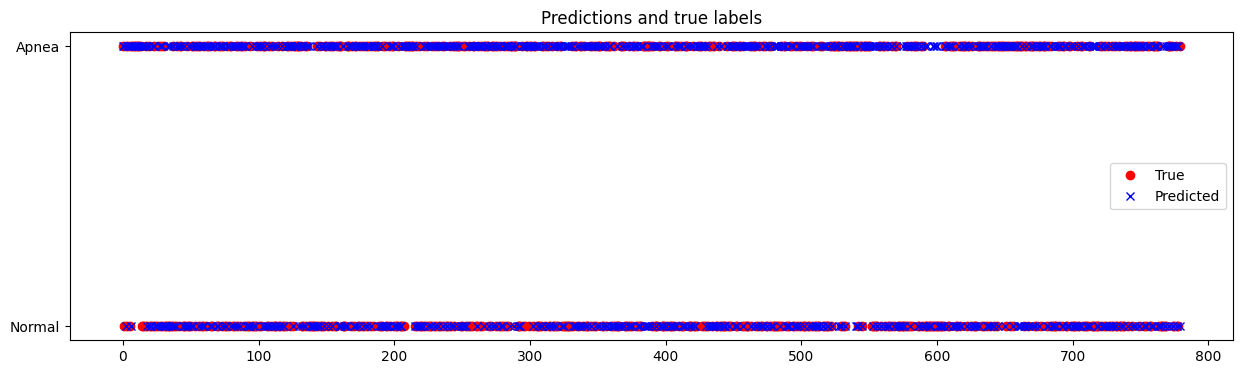

In [31]:
model_2e = xgb.XGBClassifier()
xgb_evaluation = model_evaluation(X, y, x_test_set, y_test_set, model_2e)

<i>Again the test accuracy is close to the average accuracy. The recall is 74% which is good sensitivity and majority of apnea cases are caught. Precision is 62% meaning that the model over-detects apnea. F1 score is 67% which indicates a balanced performance. It is better than random but not much more. In comparison to Random Forest the accuracy, recall and F1 score are slightly reduced.

Both of the models prioritize sensitivity over specificity and that aligns well with clinical screening goals.</i>

## Conclusion

In this project, we implemented a machine learning algorithm to detect sleep apnea using ECG-derived HRV features. Our approach involved minute ny minute segmentation of ECG recordings, R-peak detection and extraction of time- and frequency-domain HRV features. All features were extracted with careful handling of subject-specific data using Leave-One-Group-Out cross-validation to prevent data leakage.

Two classifiers were evaluated: a Random Forest and an XGBoost classifier. The Random Forest achieved a test accuracy of 66.41%, with a precision of 0.63, recall of 0.75, and F1 score of 0.68. The XGBoost classifier achieved a test accuracy of 65.77%, with a precision of 0.62, recall of 0.74, and F1 score of 0.67.

Both models showed consistent performance, with recall being notably higher than precision. This indicates that the models prioritize sensitivity, successfully identifying the majority of apnea events. In a clinical context this is beneficial. It is generally more acceptable to generate false positives than false negatives and miss critical apnea episodes. However, the moderate precision indicates that there is a lot of room to improve the specificity of predictions.

We were not able to get as good results as in the study[(2)](https://ieeexplore.ieee.org/document/898631). We followed some of the steps used in the study but did a lot differently. In the study they used polynomial classification and we used two different models. We didn't do ROC analysis which could have been beneficial. We also did cross-validation but we did it using Leave-One-Group-Out method. In the study they say they cross validated on an independent tests set of equal size but nothing is said about handling the data subject specifically. It is therefore unclear to us whether their results have excessive bias in them or not. There are a lot of differences between the study and our project which means the results can't be directly compared. Nevertheless we expected the results for our project to be better.  

Based on our results we came to the conclusion that these HRV features are not connected enough to sleep apnea detection that we could make decisions based on them. Maybe different HRV features or more of them could make better results. Different machine learning models or deep learning could also lead to better results. 